# CHUẨN BỊ DỮ LIỆU 

Nhóm gán nhãn dữ liệu bằng công cụ Label studio

File sau khi gán nhãn là: ../Data/train_final.json

# NHẬP THƯ VIỆN

In [1]:
import json
import os
import re
from pyvi import ViTokenizer
from collections import Counter
import matplotlib.pyplot as plt
import random 

In [2]:
current_folder = os.getcwd()
data_folder_path = os.path.abspath(os.path.join(current_folder, '..', 'Data'))

input_file_path = os.path.join(data_folder_path, 'train_final.json') 

output_file_path = os.path.join(data_folder_path, 'train_bio.json')

print(f"📂 Input: {input_file_path}")
print(f"💾 Output: {output_file_path}")

📂 Input: d:\STUDY DOCUMENT\4th YEAR\NLP\Vietnamese_literature\Data\train_final.json
💾 Output: d:\STUDY DOCUMENT\4th YEAR\NLP\Vietnamese_literature\Data\train_bio.json


In [3]:
def convert_json_to_bio_nested_list(json_data):
    # --- [THÊM] IN SỐ LƯỢNG ĐẦU VÀO ---
    input_count = len(json_data)
    print(f"📊 Tổng số mục dữ liệu đầu vào (Input): {input_count}")
    
    # Danh sách tổng chứa tất cả các câu
    all_sentences = []
    
    for item in json_data:
        # Lấy text gốc và label
        original_text = item.get('text') or item.get('content')
        labels = item.get('label', [])
        
        if not original_text: continue

        # 1. Tokenize bằng Pyvi
        tokenized_text = ViTokenizer.tokenize(original_text)
        tokens = tokenized_text.split()
        
        # 2. Map lại vị trí thực tế (Re-align offsets)
        token_spans = []
        current_cursor = 0
        
        for token in tokens:
            real_word = token.replace('_', ' ')
            start_index = original_text.find(real_word, current_cursor)
            
            if start_index != -1:
                end_index = start_index + len(real_word)
                token_spans.append({
                    "token": token,
                    "start": start_index,
                    "end": end_index
                })
                current_cursor = end_index

        # 3. Gán nhãn BIO và tạo cấu trúc [Token, Tag]
        sentence_pairs = [] # Chứa các cặp [Token, Tag] của 1 câu
        
        for token_info in token_spans:
            token_text = token_info['token']
            t_start = token_info['start']
            t_end = token_info['end']
            
            bio_label = "O"
            
            for lbl in labels:
                l_start = lbl['start']
                l_end = lbl['end']
                l_type = lbl['labels'][0]
                
                # Logic giao thoa vị trí
                if t_start >= l_start and t_end <= l_end:
                    if t_start == l_start:
                        bio_label = f"B-{l_type}"
                    else:
                        bio_label = f"I-{l_type}"
                    break
            
            # Làm sạch token
            clean_token = re.sub(r'[^\w\d_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂÂÊÔƠƯưăâêôơư]', '', token_text)
            
            if clean_token:
                # Thay vì tách riêng tokens/tags, ta gộp thành cặp [Token, Tag]
                sentence_pairs.append([clean_token, bio_label])
        
        # Chỉ thêm vào danh sách nếu câu có dữ liệu
        if sentence_pairs:
            all_sentences.append(sentence_pairs)

    # --- [THÊM] IN SỐ LƯỢNG ĐẦU RA ---
    output_count = len(all_sentences)
    print(f" Tổng số câu hợp lệ sau khi BIO (Output): {output_count}")
    print(f" Số câu bị loại bỏ (rỗng/lỗi): {input_count - output_count}")

    return all_sentences

In [4]:
if os.path.exists(input_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    
    # Gọi hàm đã sửa
    final_dataset = convert_json_to_bio_nested_list(raw_data)
    
    # Lưu file
    print(f"\n💾 Đang lưu vào: {output_file_path}")
    with open(output_file_path, 'w', encoding='utf-8') as f:
        json.dump(final_dataset, f, ensure_ascii=False, indent=4)

📊 Tổng số mục dữ liệu đầu vào (Input): 1136
 Tổng số câu hợp lệ sau khi BIO (Output): 1136
 Số câu bị loại bỏ (rỗng/lỗi): 0

💾 Đang lưu vào: d:\STUDY DOCUMENT\4th YEAR\NLP\Vietnamese_literature\Data\train_bio.json


# VISUALIZE

In [5]:
input_file_path = os.path.join(data_folder_path, 'train_bio.json')

In [6]:
def get_label_counts(file_path):
    if not os.path.exists(file_path):
        print("❌ Lỗi: Không tìm thấy file input.")
        return None

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        label_counter = Counter()
        total_tokens = 0
        
        # Đếm
        for sentence in data:
            for token_pair in sentence:
                if len(token_pair) >= 2:
                    tag = token_pair[1]
                    label_counter[tag] += 1
                    total_tokens += 1
        
        # In thống kê text (để xem trước)
        print(f"✅ Đã đếm xong {total_tokens} token.")
        print("-" * 30)
        for label, count in label_counter.most_common():
            print(f"{label:<15} | {count}")
        print("-" * 30)
        
        # QUAN TRỌNG: Trả về biến counter để dùng cho hàm sau
        return label_counter

    except Exception as e:
        print(f"❌ Có lỗi: {e}")
        return None

In [7]:
def plot_chart_from_counter(counter_data):
    if not counter_data:
        print("⚠️ Không có dữ liệu để vẽ.")
        return

    # 1. Lọc dữ liệu: Chỉ lấy thực thể (B-...)
    entity_data = {}
    for label, count in counter_data.items():
        if label.startswith("B-"):
            entity_name = label.replace("B-", "")
            entity_data[entity_name] = count
    
    if not entity_data:
        print("⚠️ Không tìm thấy nhãn thực thể (B-...) nào.")
        return

    # 2. Sắp xếp giảm dần
    sorted_entities = dict(sorted(entity_data.items(), key=lambda item: item[1], reverse=True))
    labels = list(sorted_entities.keys())
    values = list(sorted_entities.values())

    # 3. Vẽ Matplotlib
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color='#FF5722', edgecolor='black', alpha=0.8)
    
    # Thêm số liệu lên đầu cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title('THỐNG KÊ SỐ LƯỢNG THỰC THỂ (ENTITIES)', fontsize=14, fontweight='bold')
    plt.xlabel('Loại thực thể', fontsize=12)
    plt.ylabel('Số lượng', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
my_counter = get_label_counts(input_file_path)

✅ Đã đếm xong 23588 token.
------------------------------
O               | 16486
I-ORG           | 1142
I-TIME/DATE     | 996
B-LOC           | 800
B-TIME/DATE     | 765
I-WORK          | 734
B-ORG           | 719
B-PER           | 685
B-WORK          | 344
B-CHAR          | 317
I-PER           | 282
I-LOC           | 187
I-CHAR          | 131
------------------------------


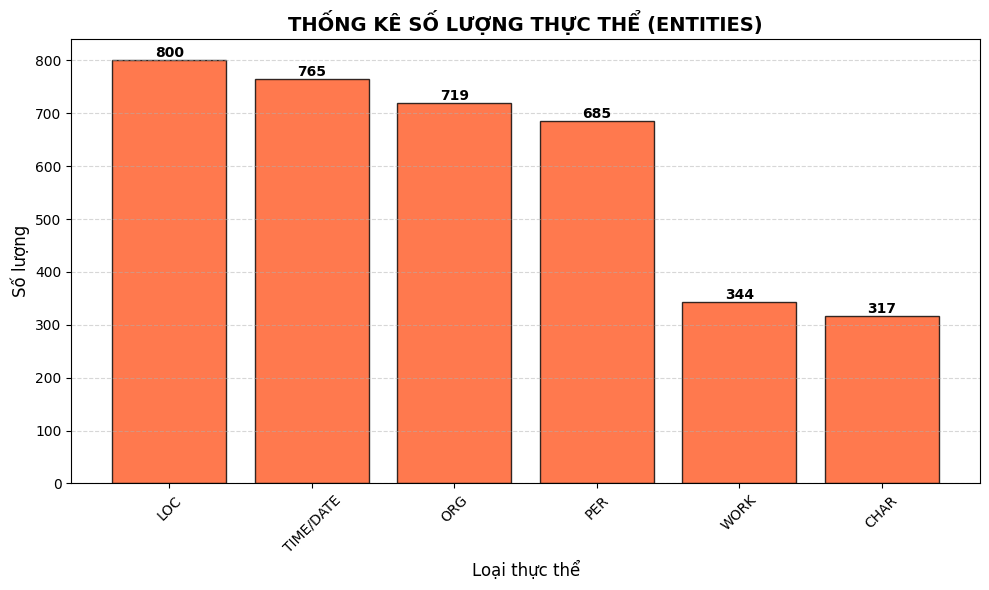

In [9]:
plot_chart_from_counter(my_counter)

# TĂNG CƯỜNG DỮ LIỆU
Bộ dữ liệu trên bị chênh lệch trầm trọng ở lớp Tác phẩm và lớp nhân vật. Do đó nhóm thực hiện tăng cường 2 lớp này bằng cách dưới đây 

In [10]:
VOCAB_AUGMENT = {
    "WORK": [
    "Vợ Chồng A Phủ","Vợ Nhặt","Làng","Chí Phèo","Đời Thừa","Sống Mòn","Đôi Mắt",
    "Lão Hạc","Dế Mèn Phiêu Lưu Ký","Truyện Tây Bắc","Rừng Xà Nu",
    "Đất Nước Đứng Lên","Những Đứa Con Trong Gia Đình","Người Mẹ Cầm Súng",
    "Mùa Lạc","Đi Bước Nữa","Vỡ Bờ","Cửa Sông","Đất Rừng Phương Nam",
    "Tuổi Thơ Dữ Dội","Nhật Ký Trong Tù","Tuyên Ngôn Độc Lập",
    "Việt Bắc","Từ Ấy","Ra Trận","Gió Lộng","Đất Nước",
    "Sóng","Thuyền Và Biển","Ánh Trăng","Tre Việt Nam","Bếp Lửa",
    "Quê Hương","Đoàn Thuyền Đánh Cá","Tiếng Hát Con Tàu",
    "Ánh Sáng Và Phù Sa","Tây Tiến","Mẹ Suốt","Mùa Xuân Nho Nhỏ",
    "Những Ngôi Sao Xa Xôi","Chiếc Lược Ngà","Bến Quê","Cỏ Lau",
    "Dấu Chân Người Lính","Thời Xa Vắng","Nỗi Buồn Chiến Tranh",
    "Mảnh Trăng Cuối Rừng","Miền Cháy","Người Lái Đò Sông Đà",
    "Vang Bóng Một Thời","Tùy Bút Sông Đà","Quê Nội","Tảng Sáng",
    "Hòn Đất","Lặng Lẽ Sa Pa","Vượt Thác","Hai Đứa Trẻ",
    "Gió Đầu Mùa","Con Chó Xấu Xí","Một Bữa No","Đôi Bạn",
    "Bắc Sơn","Sống Như Anh","Đường Chúng Ta Đi",
    "Con Trâu","Mùa Gặt","Biển","Riêng Chung","Tiếng Gà Trưa",
    "Nhớ","Bài Ca Xuân 68","Dòng Sông Thơ Ấu","Chiếc Thuyền Ngoài Xa",
    "Gặp Gỡ Cuối Năm","Làng Sen","Tấm Ván Phóng Dao",
    "Người Đàn Bà Trên Chuyến Tàu Tốc Hành",
    "Đường Về Quê Mẹ","Bài Thơ Về Tiểu Đội Xe Không Kính",
    "Trường Sơn Đông Trường Sơn Tây","Đồng Chí","Lửa Thiêng",
    "Lúa Non","Quê Mẹ","Bài Ca Chim Chơ Rao","Dáng Đứng Việt Nam",
    "Ánh Sáng","Phù Sa","Đường Ra Trận","Mẹ Tơm",
    "Đất Lửa","Quê Hương Việt Bắc","Cái Chết Của Con Thiên Nga",
    "Bài Ca Trên Núi","Sông Đông Êm Đềm","Thép Đã Tôi Thế Đấy",
    "Người Con Gái Việt Nam","Người Chiến Sĩ Trường Sơn",
    "Bài Ca Người Lính","Người Mẹ Việt Nam",
    "Người Thanh Niên Xung Phong","Người Lính Lái Xe",
    "Người Dân Làng Chài","Người Phụ Nữ Việt Nam",
    "Người Nông Dân Việt Nam","Người Trí Thức Việt Nam",
    "Người Mẹ Anh Hùng","Người Con Xa Quê",
    "Người Chiến Sĩ Giải Phóng","Người Lính Trẻ",
    "Người Dân Nam Bộ","Người Dân Tây Nguyên",
    "Người Con Việt Bắc","Người Lính Già",
    "Người Mẹ Miền Trung","Người Cha Trong Chiến Tranh",
    "Người Con Trong Gia Đình","Người Kể Chuyện",
    "Người Đọc Nhật Ký","Người Viết Văn","Người Làm Thơ"
],
    "CHAR": [
    "Chí Phèo", "Thị Nở", "Lão Hạc", "Xuân Tóc Đỏ", "Mị", "A Phủ", 
    "Tràng", "Bá Kiến", "Chị Dậu", "Huấn Cao",
    "Tnú", "Nguyệt", "Phùng", "Đẩu", "A Phủ","Mị","Tràng","Thị","Bà Cụ Tứ","Ông Hai",
    "Hộ","Lão Hạc","Ông Giáo","Dế Mèn","Dế Trũi","Tnú","Cụ Mết","Mai","Việt","Chiến",
    "Má Việt","Anh Núp","An","Ba","Tư Hoạch","Bé Thu","Ông Sáu","Nguyệt","Phương",
    "Nhĩ","Phùng","Kiên","Hạnh","Giang","Lực","Sứ",
    "Ba Đô","Thơm","Thái","Cụ Phó Bảng","Lượm","Liên","An",
    "Huấn Cao","Quản Ngục","Thầy Điền","Lang Rận",
    "Chị Dậu","Anh Dậu","Cai Lệ","Nghị Quế","Xuân","Sen","Chính","Hà","Hồng",
    "Bé Hồng","Tâm","Loan","Dũng","Phúc","Tuyết","Ngân","Nga","Nho",
    "Phương Định","Chị Thao","Cúc","Vân","Bình","Quang","Hoài","Trí","Linh",
    "Sơn","Thắng","Minh","Tuấn","Hải","Long","Nam","Hòa","Khánh","Thành",
    "Tấn","Phong","Đạt","Thảo","Oanh","Mai Anh","Thu Hà","Lan","Huệ","Yến",
    "Ngọc","Kim","Thanh","Tú","Uyên","Vy","Bích","Hương","Thúy",
    "Mẹ Suốt","Ông Tư","Chú Năm","Anh Ba","Anh Sáu",
    "Chị Út","Cô Út"
]

}

In [11]:
def create_augmented_segment(text, label_type):
    """
    Chuyển một từ vựng (ví dụ: 'Lão Hạc') thành format BIO list
    Output: [['Lão', 'B-WORK'], ['Hạc', 'I-WORK']] hoặc [['Lão_Hạc', 'B-WORK']] tùy tokenizer
    """
    # 1. Tokenize từ mới cho chuẩn format Pyvi
    tokenized_word = ViTokenizer.tokenize(text)
    tokens = tokenized_word.split()
    
    segment = []
    for i, token in enumerate(tokens):
        # Token đầu tiên là B-, các token sau là I-
        tag = f"B-{label_type}" if i == 0 else f"I-{label_type}"
        segment.append([token, tag])
        
    return segment

def augment_data(input_data, target_labels=['WORK', 'CHAR'], num_aug=2):
    augmented_dataset = []
    
    print(f"🔄 Đang xử lý {len(input_data)} câu gốc...")
    
    for sentence in input_data:
        # Thêm câu gốc vào tập dữ liệu trước
        augmented_dataset.append(sentence)
        
        # 1. Xác định vị trí các thực thể trong câu
        # entities_map = [ {'start': 0, 'end': 2, 'type': 'WORK'}, ... ]
        entities_found = []
        i = 0
        while i < len(sentence):
            token_pair = sentence[i]
            # Kiểm tra cấu trúc cặp [Token, Label]
            if len(token_pair) < 2: 
                i += 1
                continue
                
            tag = token_pair[1]
            
            # Nếu gặp thẻ B- của loại cần Augment (WORK/CHAR)
            is_target = False
            found_type = ""
            for t_type in target_labels:
                if tag == f"B-{t_type}":
                    is_target = True
                    found_type = t_type
                    break
            
            if is_target:
                start = i
                end = i
                # Tìm điểm kết thúc của thực thể (quét các thẻ I- liên tiếp)
                while end + 1 < len(sentence):
                    next_tag = sentence[end+1][1]
                    if next_tag == f"I-{found_type}":
                        end += 1
                    else:
                        break
                
                entities_found.append({
                    'start': start,
                    'end': end,
                    'type': found_type
                })
                i = end + 1
            else:
                i += 1
        
        # 2. Nếu câu có chứa thực thể cần augment -> Tạo câu mới
        if entities_found:
            for _ in range(num_aug):
                # Copy câu gốc (shallow copy list of lists)
                new_sentence = [pair[:] for pair in sentence]
                
                # Duyệt NGƯỢC từ cuối lên đầu để thay thế (tránh làm lệch index)
                for ent in reversed(entities_found):
                    l_type = ent['type']
                    start = ent['start']
                    end = ent['end']
                    
                    # Chọn từ mới ngẫu nhiên từ từ điển
                    new_text = random.choice(VOCAB_AUGMENT[l_type])
                    
                    # Tạo segment BIO mới
                    new_segment = create_augmented_segment(new_text, l_type)
                    
                    # THAY THẾ: Cắt đoạn cũ [start:end+1] thay bằng segment mới
                    # Python list slicing assignment: list[a:b] = new_list
                    new_sentence[start : end + 1] = new_segment
                
                augmented_dataset.append(new_sentence)

    return augmented_dataset

In [12]:
base_path = os.path.join('..', 'Data')
input_file = os.path.join(base_path, 'train_bio.json')
output_file = os.path.join(base_path, 'train_bio_augmented.json')

if os.path.exists(input_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        original_data = json.load(f)
    
    # Thực hiện augment: Mỗi câu chứa WORK/CHAR sẽ đẻ thêm 3 câu mới
    final_data = augment_data(original_data, target_labels=['WORK', 'CHAR'], num_aug=3)
    
    # Shuffle dữ liệu để model học tốt hơn
    random.shuffle(final_data)
    
    print(f"\n✅ Kết quả:")
    print(f"- Số câu gốc: {len(original_data)}")
    print(f"- Tổng số câu sau Augment: {len(final_data)}")
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(final_data, f, ensure_ascii=False, indent=4)
    print(f"💾 Đã lưu file: {output_file}")
    
else:
    print("❌ Không tìm thấy file train_bio.json")

🔄 Đang xử lý 1136 câu gốc...

✅ Kết quả:
- Số câu gốc: 1136
- Tổng số câu sau Augment: 2225
💾 Đã lưu file: ..\Data\train_bio_augmented.json


In [13]:
input_file_path2 = os.path.join(base_path, 'train_bio_augmented.json')

In [14]:
my_counter2 = get_label_counts(input_file_path2)

✅ Đã đếm xong 48963 token.
------------------------------
O               | 35644
I-WORK          | 2095
I-ORG           | 1502
I-TIME/DATE     | 1476
B-WORK          | 1376
B-TIME/DATE     | 1299
B-CHAR          | 1268
B-PER           | 1183
B-LOC           | 1061
B-ORG           | 956
I-PER           | 537
I-CHAR          | 292
I-LOC           | 274
------------------------------


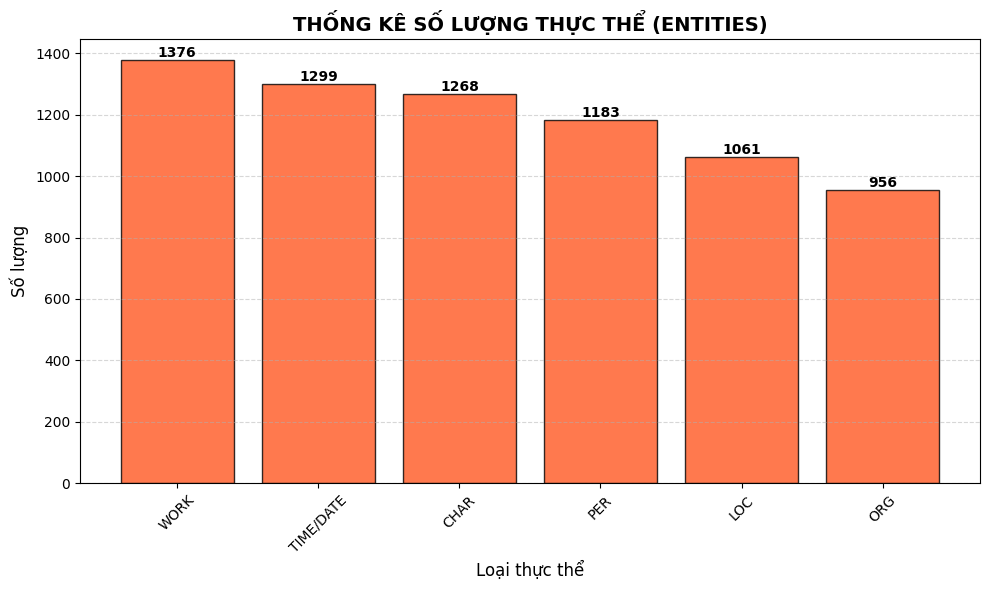

In [16]:
plot_chart_from_counter(my_counter2)